<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/dev_floatmap/cnn_adjusted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt
import random

def plot_random_element(X_train_map):
    index = random.randint(0, len(X_train_map) - 1)  # Pick a random index
    element = X_train_map[index, :, :, 0]  # Retrieve the element

    plt.figure(figsize=(8, 6))
    plt.imshow(element, cmap='viridis', origin='lower')
    plt.title(f"Random Element from X_train_map (Index {index})")
    plt.colorbar(label='Intensity')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.show()


    



In [24]:
def plot5(X_test_map, particle_vector):

  # Plotting random maps with information

  # Select 5 random indices from the test data
  random_indices = np.random.choice(range(X_test_map.shape[0]), size=5, replace=False)

  # Create a subplot with 5 rows and 1 column
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the random indices and plot each map with information
  for i, index in enumerate(random_indices):
      # Get the map and corresponding information
      map_data = X_test_map[index, :, :, 0]
      mass_category = particle_vector[index].mass_category
      ckov = particle_vector[index].ckov
      mip_position = particle_vector[index].mip_position
      momentum = particle_vector[index].momentum
      
      # Plot the map
      axes[i].imshow(map_data, cmap='gray')
      
      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0], mip_position[1], 'ro')
      
      # Set the title with the information    a
      #x.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position:.4f}, Momentum: {momentum:.4f}")
      mip_pos = f"{mip_position:.4f}"
      axes[i].set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_pos}, Momentum: {momentum}")
      axes[i].axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [25]:
def create_lr_scheduler(num_epochs = 10):

  tf.random.set_seed(42)
  div = num_epochs/4
  print("div =", div)
  print("1e-4 * 10**(epoch/div) = ", 1e-4 * 10**(num_epochs/div))
  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/div)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
  return lr_scheduler





def plot_lr(num_epochs = 10, history = None):
  div = num_epochs/4
  lrs = 1e-4 * (10 ** (np.arange(num_epochs)/div))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")

  plt.title("Learning rate vs. loss");

Dimensions of the input data:
Training:
  X_train_map = (7816, 144, 160, 1)
  X_train_momentum = (7816, 1)
  X_train_refractive_index = (7816, 1)
  X_train_mip_position = (7816, 2)
  y_train = (7816, 3)
Testing:
  X_test_map = (1955, 144, 160, 1)
  X_test_momentum = (1955, 1)
  X_test_refractive_index = (1955, 1)
  X_test_mip_position = (1955, 2)
  y_test = (1955, 3)


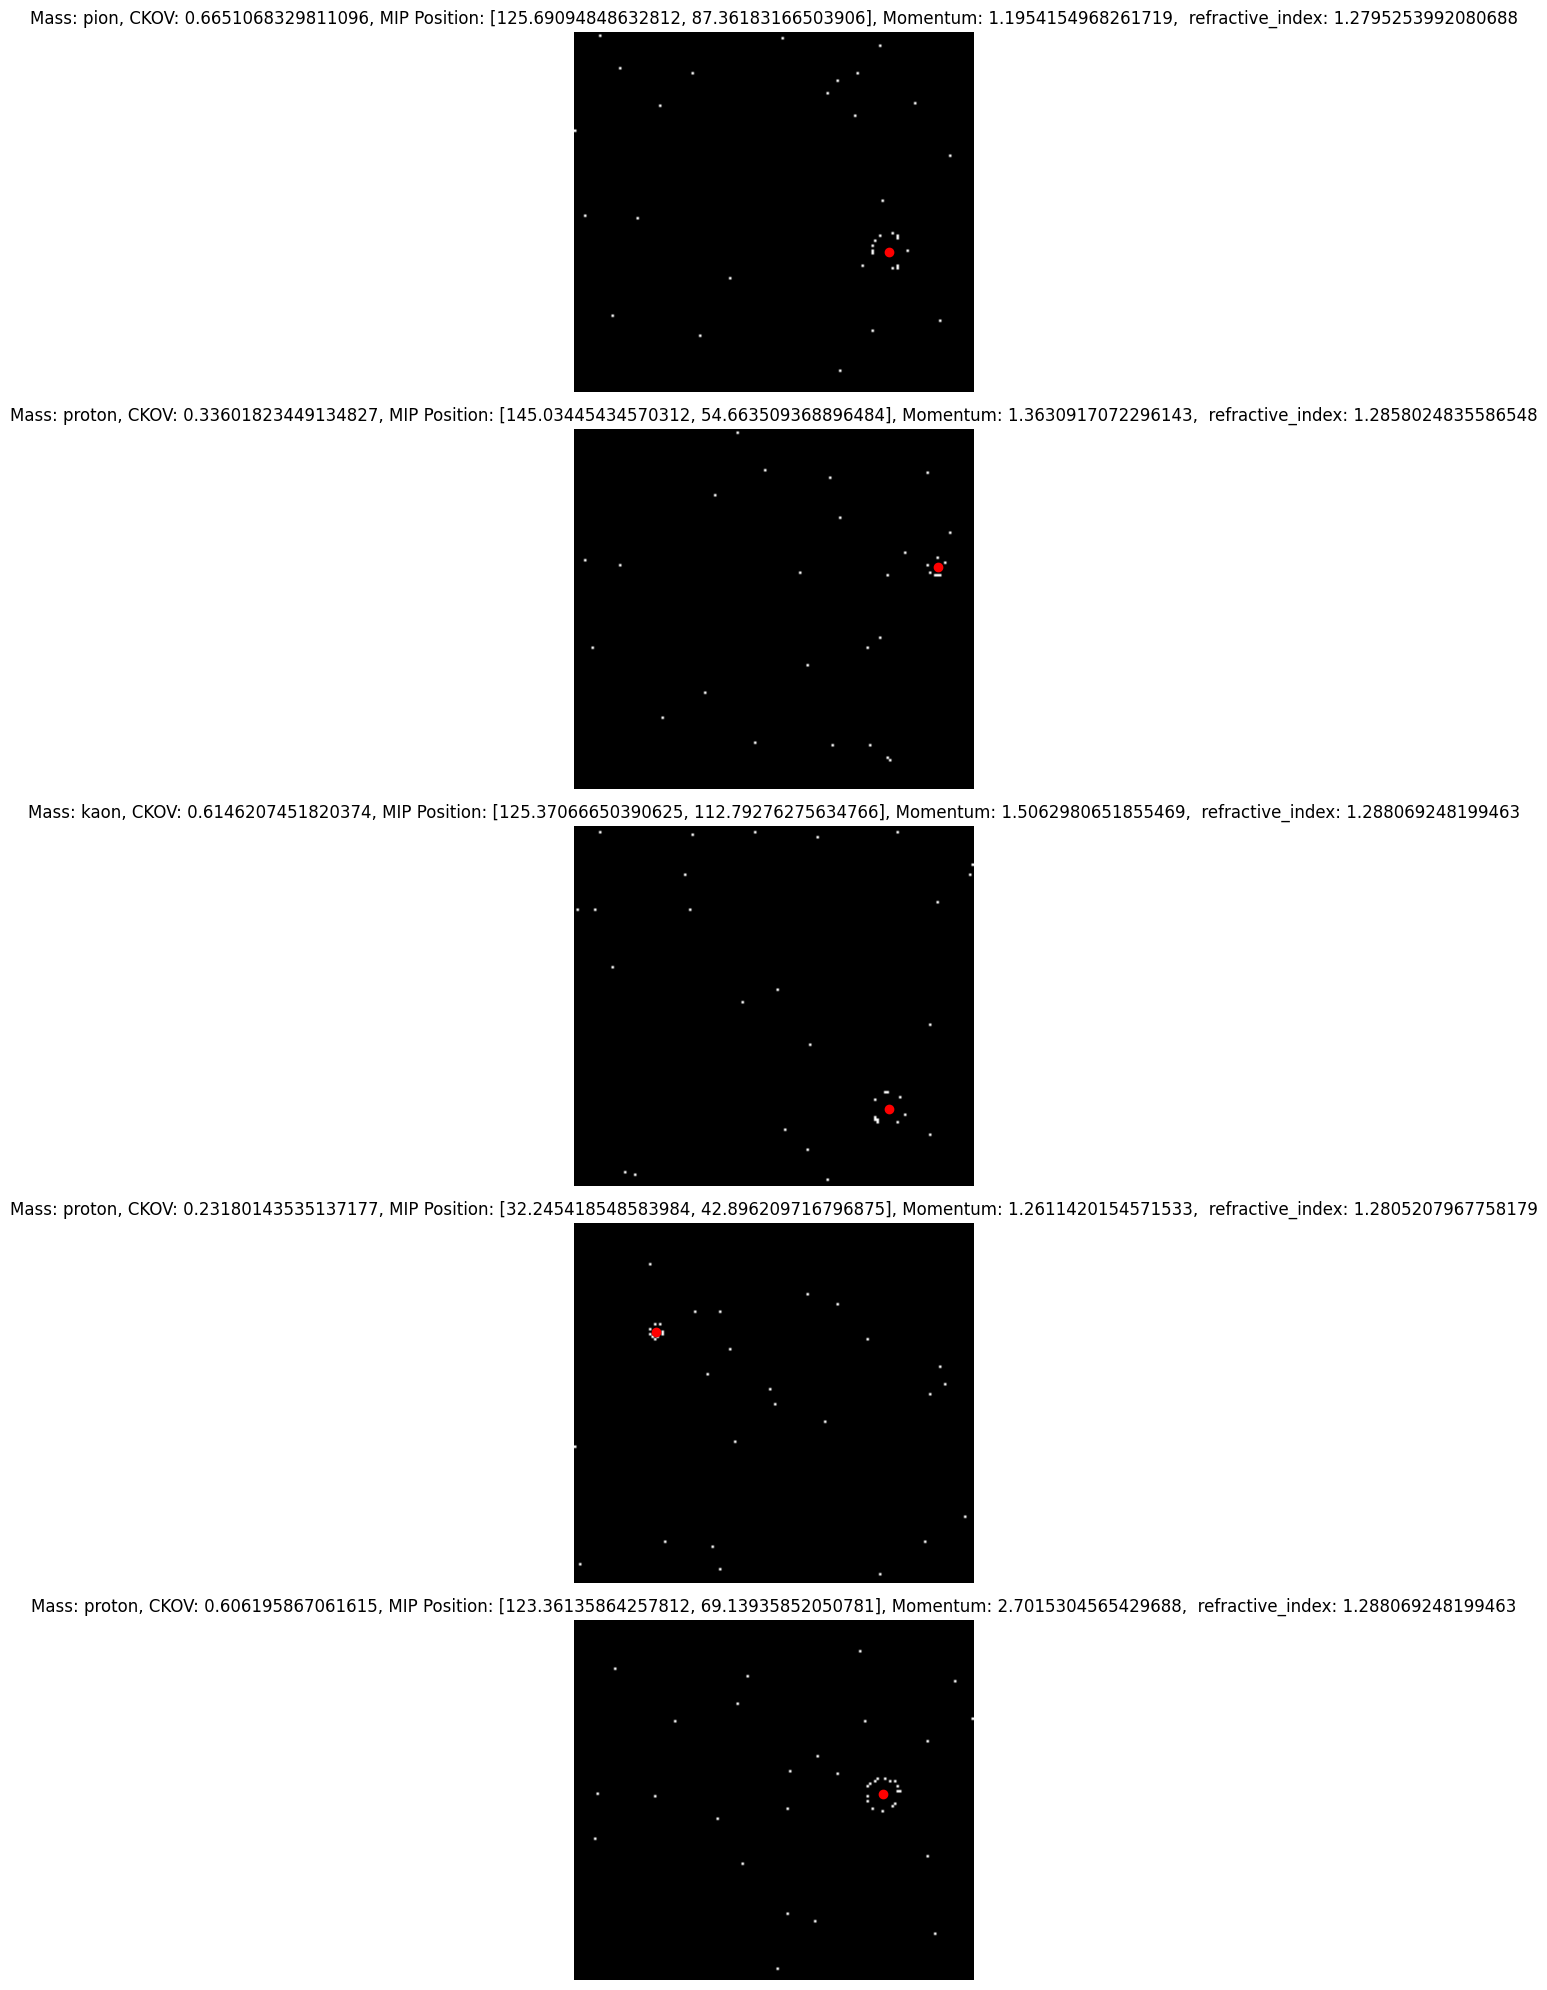

Epoch 1/100
245/245 [==============================] - 14s 40ms/step - loss: 15.7281 - accuracy: 0.3320 - val_loss: 10.3326 - val_accuracy: 0.3182
Epoch 2/100
245/245 [==============================] - 9s 37ms/step - loss: 6.9457 - accuracy: 0.3374 - val_loss: 4.2736 - val_accuracy: 0.3202
Epoch 3/100
245/245 [==============================] - 9s 38ms/step - loss: 3.1925 - accuracy: 0.3458 - val_loss: 2.3574 - val_accuracy: 0.3253
Epoch 4/100
245/245 [==============================] - 9s 37ms/step - loss: 2.1254 - accuracy: 0.3352 - val_loss: 1.8688 - val_accuracy: 0.3315
Epoch 5/100
245/245 [==============================] - 9s 37ms/step - loss: 1.8536 - accuracy: 0.3310 - val_loss: 1.7279 - val_accuracy: 0.3432
Epoch 6/100
245/245 [==============================] - 9s 37ms/step - loss: 1.7351 - accuracy: 0.3406 - val_loss: 1.6275 - val_accuracy: 0.3371
Epoch 7/100
245/245 [==============================] - 9s 37ms/step - loss: 1.6435 - accuracy: 0.3362 - val_loss: 1.5559 - val_accura

In [ ]:
print_vals = False

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers


np.set_printoptions(precision=4)


class ParticleDataUtils:
    class ParticleInfo:
        def __init__(self, momentum, mass, refractiveIndex, ckov, filledBins, mip_position):
            self.momentum = momentum
            self.mass = mass
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins
            self.mip_position = mip_position
            self.mass_category = self.infer_mass_category(mass)  # Infer mass category based on mass
            
        @staticmethod
        def infer_mass_category(mass):
            pion_mass = 0.1396
            proton_mass = 0.938
            kaon_mass = 0.4937

            if abs(mass - pion_mass) < 1e-6:
                return "pion"
            elif abs(mass - kaon_mass) < 1e-6:
                return "kaon"
            elif abs(mass - proton_mass) < 1e-6:
                return "proton"
            else:
                return "unknown"
        def __str__(self):
            return (f"ParticleInfo(momentum={self.momentum}, mass={self.mass}, refractiveIndex={self.refractiveIndex}, "
                    f"ckov={self.ckov}, num_filled_bins={len(self.filledBins)}, mip_position={self.mip_position})")

def save_particle_info_to_hdf5(particle_vector, filename):
    with h5py.File(filename, 'w') as file:
        for i, particle in enumerate(particle_vector):
            # Create a group for each particle
            group = file.create_group(f'Particle{i}')

            # Store scalar values
            group.attrs['Momentum'] = particle.momentum
            group.attrs['Mass'] = particle.mass
            group.attrs['RefractiveIndex'] = particle.refractiveIndex
            group.attrs['Ckov'] = particle.ckov
            group.attrs['MassCategory'] = particle.mass_category  # Save the mass category
            group.attrs['MipPos'] = particle.mip_position  # Save the MIP position X coordinate

            # Store filledBins to HDF5 file
            group.create_dataset("FilledBins", data=np.array(particle.filledBins, dtype=[('x', 'f'), ('y', 'f')]))


def print_hdf5_items(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}")
    elif isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Attribute):
        print(f"Attribute: {name}")


def load_particle_info_from_hdf5(filename):
    particle_vector = []
    
    with h5py.File(filename, 'r') as file:
        #file.visititems(print_hdf5_items)
        for i, group_name in enumerate(file):
            group = file[group_name]

            # Read scalar values
            momentum = group.attrs['Momentum']
            mass = group.attrs['Mass']
            refractiveIndex = group.attrs['RefractiveIndex']
            ckov = group.attrs['Ckov']
            mip_position = group['MipPos']
            mip_position = mip_position[...]  # Retrieve the data as a numpy array

            mip_position = mip_position.tolist()  # Convert the numpy array to a list

            # Read filledBins
            filled_bins_dataset = group['FilledBins']
            filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

            filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

            particle_info = ParticleDataUtils.ParticleInfo(
                momentum, mass, refractiveIndex, ckov, filledBins=filled_bins, mip_position=mip_position)
            if print_vals == True:
              print(particle_info)  # This will use the __str__() method of ParticleInfo

            particle_vector.append(particle_info)

    return particle_vector


def read_particle_data_from_file(filename="particle.h5", percentage=100.0):
    drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
    file_path = os.path.join(drive_path, filename)
    particle_vector = load_particle_info_from_hdf5(file_path)

    # Calculate the number of particles based on the percentage
    num_particles = int(len(particle_vector) * (percentage / 100.0))

    # Slice the particle_vector to the desired percentage
    particle_vector = particle_vector[:num_particles]

    return particle_vector


# Example usage
filename = 'ParticleInfo.h5'
percentage_to_read = 100.0  # Read only 50% of the dataset
particle_vector = read_particle_data_from_file(filename, percentage=percentage_to_read)

# Create an empty list to store the map_data for all particles
map_data_list = []

# Create an empty 2D map
map_shape = (144, 160)
map_data = np.zeros(map_shape)

# Iterate over all particles in the particle_vector
X_train_mip_position = []
for i, particle in enumerate(particle_vector):
    # Reset the map_data for each particle
    map_data = np.zeros(map_shape)
    X_train_mip_position.append(np.array(particle.mip_position))

    for entry in particle.filledBins:
        x = int(round(entry[0]))
        y = int(round(entry[1]))
        # Shift the coordinates to the center
        if 0 <= y < map_shape[0] and 0 <= x < map_shape[1]:
            map_data[y, x] = 1

    # Add the map_data to the list
    map_data_list.append(map_data)

# Convert the map_data_list to a NumPy array
map_data_array = np.array(map_data_list)

X_train_mip_position = np.array(X_train_mip_position)

# Prepare the training data
X_train_map = map_data_array  # Use the map_data_array as X_train_map
X_train_momentum = np.array([particle.momentum for particle in particle_vector])
X_train_refractive_index = np.array([particle.refractiveIndex for particle in particle_vector])

# One-hot encode the labels
label_binarizer = LabelBinarizer()
label_binarizer.classes_ = np.array(["pion", "kaon", "proton"])
y_train_encoded = label_binarizer.fit_transform([particle.mass_category for particle in particle_vector])

# Create a scaler object
std_scaler = StandardScaler()

# Fit and transform the data
X_train_momentum = X_train_momentum.reshape(-1, 1)
X_train_momentum = std_scaler.fit_transform(X_train_momentum)

X_train_refractive_index = X_train_refractive_index.reshape(-1, 1)
X_train_refractive_index = std_scaler.fit_transform(X_train_refractive_index)

X_plot = X_train_map
X_plot = X_plot.reshape(X_train_map.shape[0], X_train_map.shape[1], X_train_map.shape[2], 1)

num_samples = y_train_encoded.shape[1]

# Split the data into train and test sets
X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, X_train_mip_position, X_test_mip_position, y_train, y_test = train_test_split(
    X_train_map,
    X_train_momentum,
    X_train_refractive_index,
    X_train_mip_position,
    y_train_encoded,
    test_size=0.2,
    random_state=42
)




# Reshape the input map to include the channel dimension
X_train_map = X_train_map.reshape(X_train_map.shape[0], X_train_map.shape[1], X_train_map.shape[2], 1)
X_test_map = X_test_map.reshape(X_test_map.shape[0], X_test_map.shape[1], X_test_map.shape[2], 1)

# Define input shapes
map_shape = X_train_map.shape[1:]
momentum_shape = (1,)
refractive_index_shape = (1,)
mip_position_shape = (2,)

# Define inputs
map_input = Input(shape=map_shape, name='map_input')
momentum_input = Input(shape=momentum_shape, name='momentum_input')
refractive_index_input = Input(shape=refractive_index_shape, name='refractive_index_input')
mip_position_input = Input(shape=mip_position_shape, name='mip_position_input')

# Define convolutional layers for the map input
conv1 = Conv2D(16, (5, 5), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.005), bias_regularizer=regularizers.l2(0.01))(map_input)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU()(conv1)
conv1 = MaxPooling2D((2, 2))(conv1)
conv1 = Dropout(0.15)(conv1)

conv2 = Conv2D(64, (9, 9), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.005), bias_regularizer=regularizers.l2(0.01))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU()(conv2)
conv2 = MaxPooling2D((2, 2))(conv2)
conv2 = Dropout(0.15)(conv2)

conv3 = Conv2D(16, (13, 13), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.005), bias_regularizer=regularizers.l2(0.01))(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU()(conv3)
conv3 = MaxPooling2D((2, 2))(conv3)
conv3 = Dropout(0.15)(conv3)

# Flatten
flat_map = Flatten()(conv3)

# Concatenate map features with other inputs
concat = concatenate([flat_map, momentum_input, refractive_index_input, mip_position_input])

# Define fully connected layers
fc1 = Dense(64, kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), bias_regularizer=regularizers.l2(0.01))(concat)
fc1 = BatchNormalization()(fc1)
fc1 = LeakyReLU()(fc1)
fc1 = Dropout(0.2)(fc1)

fc2 = Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), bias_regularizer=regularizers.l2(0.01))(fc1)
fc2 = BatchNormalization()(fc2)
fc2 = LeakyReLU()(fc2)
fc2 = Dropout(0.2)(fc2)

output = Dense(3, activation='softmax')(fc2)  # Predicting mass categories

# Define the model
model = Model(inputs=[map_input, momentum_input, refractive_index_input, mip_position_input], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the shapes of the input data
print("Dimensions of the input data:")
print("Training:")
print("  X_train_map =", X_train_map.shape)
print("  X_train_momentum =", X_train_momentum.shape)
print("  X_train_refractive_index =", X_train_refractive_index.shape)
print("  X_train_mip_position =", X_train_mip_position.shape)
print("  y_train =", y_train.shape)
print("Testing:")
print("  X_test_map =", X_test_map.shape)
print("  X_test_momentum =", X_test_momentum.shape)
print("  X_test_refractive_index =", X_test_refractive_index.shape)
print("  X_test_mip_position =", X_test_mip_position.shape)
print("  y_test =", y_test.shape)

# Set the percentage of the training set to plot (e.g., 20%)
percentage_to_plot = 0.05 / 10000

# Calculate the starting index of the samples to plot

start_index = -num_samples

# Create a subplot with the number of rows based on the number of samples
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

# Iterate over the samples and plot each map with information
for i, ax in enumerate(axes):
    # Get the map and corresponding information
    map_data = X_plot[start_index + i, :, :, 0]
    mass_category = particle_vector[start_index + i].mass_category
    ckov = particle_vector[start_index + i].ckov
    mip_position = particle_vector[start_index + i].mip_position
    momentum = particle_vector[start_index + i].momentum
    refractive_index = particle_vector[start_index + i].refractiveIndex

    # Plot the map
    ax.imshow(map_data, cmap='gray')

    # Add a red dot at the MIP position
    ax.plot(mip_position[0], mip_position[1], 'ro')

    # Set the title with the information
    ax.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Train the model
history = model.fit(
    x=[X_train_map, X_train_momentum, X_train_refractive_index, X_train_mip_position],
    y=y_train,
    validation_data=([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position], y_test),
    epochs=100,
    verbose=1
)


# particle_vector er korrekt, feilen skjer et annet sted?


print("\n Training Set split \n\n")

if print_vals == True:
  for p in particle_vector:
    print(p)
    ckov = np.arccos(np.sqrt(p.momentum**2 + p.mass**2)/(p.momentum*p.refractiveIndex))
    print(ckov)

7/7 [==============================] - 0s 9ms/step


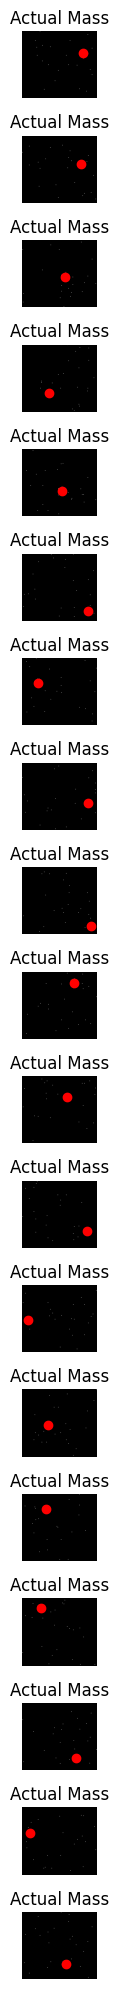

In [60]:
# 1. Predict labels on validation data
y_pred = model.predict([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position])

# 2. Calculate the difference between predicted and actual labels
losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

# Sort the indices of the losses from highest to lowest
sorted_indices = np.argsort(losses)[::-1]

# Get the indices of the worst performing 10%
worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

# Create figure and axes
num_plots = len(worst_10_percent_indices)
#fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
fig, axes = plt.subplots(num_plots,figsize=(8, 20))

# Define mass categories
mass_categories = ["pion", "kaon", "proton"]

# 3. Create plots for these cases, including their feature information and predicted vs actual labels
for i, index in enumerate(worst_10_percent_indices):
    # Get the map and corresponding information
    map_data = X_plot[index, :, :, 0]
    actual_mass_category = mass_categories[np.argmax(y_test[index])]
    predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
    ckov = particle_vector[index].ckov
    mip_position = particle_vector[index].mip_position
    momentum = particle_vector[index].momentum
    refractive_index = particle_vector[index].refractiveIndex
    
    mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)
    
    # Check if the value is NaN (invalid Cherenkov angle)
    if np.isnan(mass_actual):
        mass_actual = "Invalid"

    # Plot the map
    axes[i].imshow(map_data, cmap='gray')

    # Add a red dot at the MIP position
    axes[i].plot(mip_position[0], mip_position[1], 'ro')

    # Set the title with the information
    axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
    #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

    #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


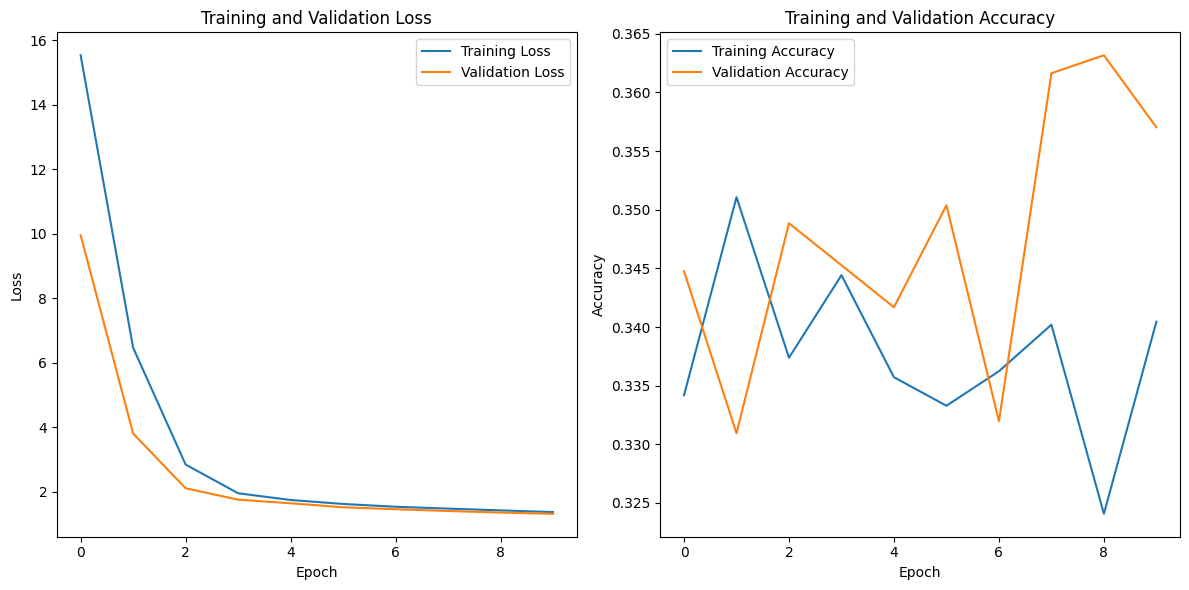

In [62]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 9ms/step


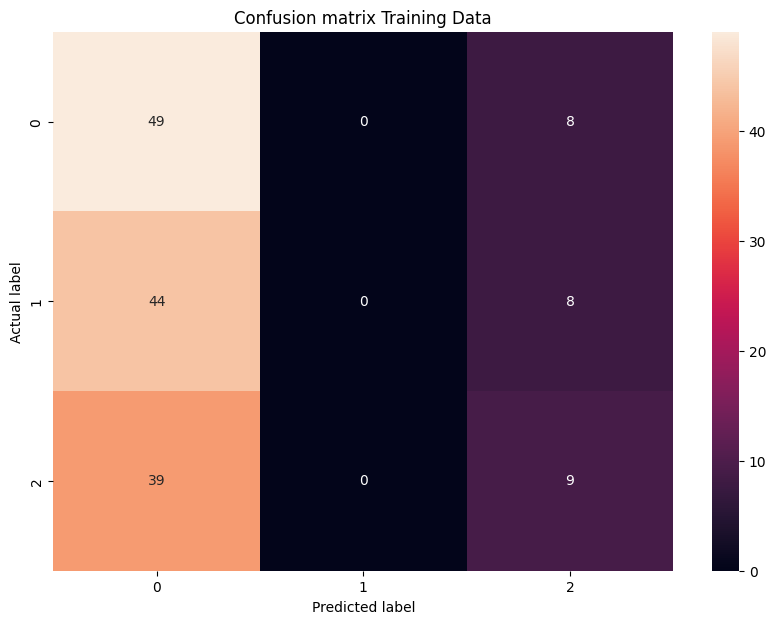

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data


y_train_pred = model.predict([X_train_map, X_train_momentum, X_train_refractive_index, X_train_mip_position])

# Convert the predictions from categorical back to original labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Calculate the confusion matrix
#cm = confusion_matrix(y_train, y_train_pred_classes)

# Calculate the confusion matrix
rounded_labels=np.argmax(y_train, axis=1)

cm = confusion_matrix(rounded_labels, y_train_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Training Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


2/2 [==============================] - 0s 8ms/step


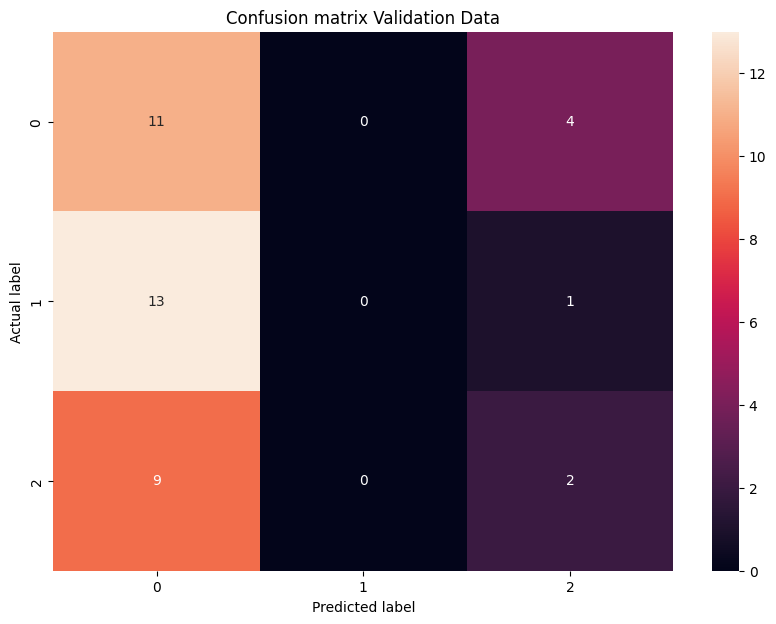

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_val_pred = model.predict([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position])

# Convert the predictions from categorical back to original labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)

cm = confusion_matrix(rounded_labels, y_val_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Validation Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
